# Проект e-commerce: вариант 1 


#### В рамках проекта нам необходимо провести анализ покупок в онлайн магазине и ответить на следующие вопросы:

1. Найти количество пользователей, которые совершили покупку только один раз.

2. Найти количество заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам). 

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

6. Построить RFM-кластеры для пользователей. Вывести для каждого кластера средние значения метрик R, F, M.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import timedelta
from calendar import monthrange
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
users = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv',
                    parse_dates=['order_purchase_timestamp',
                                'order_approved_at',
                                'order_delivered_carrier_date',
                                'order_delivered_customer_date',
                                'order_estimated_delivery_date'])
items = pd.read_csv('olist_order_items_dataset.csv',
                   parse_dates=['shipping_limit_date'])

In [3]:
users.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
users.shape

(99441, 5)

In [5]:
users.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
users.duplicated().sum()

0

In [7]:
users.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [9]:
orders.shape

(99441, 8)

In [10]:
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [11]:
orders.duplicated().sum()

0

In [12]:
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [13]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [14]:
items.shape

(112650, 7)

In [15]:
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [16]:
items.duplicated().sum()

0

In [17]:
items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

## Задание 1

Будем считать покупками любые заказы, в столбце "order_status" которых, не стоит статус "created", т.к. данные заказы не оплачены и покупками не являются. Для формирования интересующего нас датафрейма покупок, мы можем объединить таблицу orders с таблицей users, а затем, для каждого уникального покупателя (customer_unique_id) рассчитаем суммарное количество заказов и оставим покупателей с одним заказом. 


In [18]:
orders.order_status.unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [19]:
orders[~orders.order_status.isin(['created'])] \
    .merge(
        users[['customer_id', 'customer_unique_id']], 
        on='customer_id', 
        how='left'
    ) \
    .groupby('customer_unique_id') \
    .agg({'order_id': 'nunique'}) \
    .value_counts()

order_id
1           93096
2            2744
3             203
4              30
5               8
6               6
7               3
17              1
9               1
dtype: int64

**93096** пользователей совершили покупку только один раз

## Задание 2

Для расчета количества недоставленных заказов в месяц, будем работать только с отмененными или недоступными заказами (статус "canceled" или "unavailable"), т.к. данные заказы можно однозначно считать недоставленными. Для каждого месяца покупки и каждого статуса, рассчитаем уникальное количество заказов и затем, для каждого статуса рассчитаем среднее число заказов по месяцам.

In [20]:
orders['month_of_purchase'] = orders.order_purchase_timestamp.dt.to_period('M')

In [21]:
orders[orders.order_status.isin(['unavailable', 'canceled'])] \
    .groupby(['month_of_purchase', 'order_status'], as_index=False) \
    .agg({'order_id': 'nunique'}) \
    .groupby('order_status', as_index=False) \
    .order_id.mean()

,order_status,order_id
0,canceled,26.041667
1,unavailable,29.000000


В среднем по причине отмены не доставляется **26** заказов в месяц, по причине недоступности товара - **25** заказов в месяц.


## Задание 3

По каждому товару определить, в какой день недели товар чаще всего покупается. Для этого примерджим к таблице items поле order_approved_at из таблицы orders. Затем к полученной таблице добавим столбец с названием дня недели совершения покупки. 

In [22]:
 items_approved = items.merge(orders[['order_id', 'order_approved_at']], on='order_id', how='inner')

In [23]:
items_approved.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 09:45:35
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 11:05:13
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:48:30
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:10:18
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 14:10:13


Заказы с отсутствующей датой подтверждения оплаты, однако статаус указан как "delivered" и остальные поля заполнены (возможно ошибка) 

In [24]:
items_approved[items_approved.order_approved_at.isna()]

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_approved_at
8204,12a95a3c06dbaec84bcfb0e2da5d228a,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77,NaT
19005,2babbb4b15e6d2dfe95e2de765c97bce,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 16:15:03,79.99,26.82,NaT
20473,2eecb0d85f281280f79fa00f9cec1a95,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23,NaT
26393,3c0b8706b065f9919d0505d3b3343881,1,db8ed3d08891d16a2438a67ab3acb740,004c9cd9d87a3c30c522c48c4fc07416,2017-02-22 14:53:27,133.99,23.20,NaT
36128,51eb2eebd5d76a24625b31c33dd41449,1,7868a64aa111bbb4f41f8e1146c0becb,cca3071e3e9bb7d12640c9fbe2301306,2017-02-28 14:52:27,59.90,17.16,NaT
40822,5cf925b116421afa85ee25e99b4c34fb,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82,NaT
49309,7002a78c79c519ac54022d4f8a65e6e8,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52,NaT
49336,7013bcfc1c97fe719a7b5e05e61c12db,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53,NaT
59699,88083e8f64d95b932164187484d90212,1,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52,NaT
59700,88083e8f64d95b932164187484d90212,2,8c5876b1c7768217964f353bc7e64393,0db783cfcd3b73998abc6e10e59a102f,2017-02-22 21:49:19,49.00,14.52,NaT


Удалим заказы с отсутствующей датой подтверждения оплаты для исключения ошибок

In [25]:
items_approved = items_approved.dropna(subset=['order_approved_at'])

In [26]:
items_approved['weekday_of_approve'] = items_approved.order_approved_at.dt.day_name()

In [27]:
ind = items_approved \
    .groupby(['product_id', 'weekday_of_approve'], as_index=False) \
    .agg({'order_item_id': 'nunique'}) \
    .groupby('product_id') \
    .order_item_id.idxmax()

In [28]:
shopping_days = items_approved[['product_id', 'weekday_of_approve']].iloc[ind]
shopping_days.head()

,product_id,weekday_of_approve
0,4244733e06e7ecb4970a6e2683c13e61,Wednesday
1,e5f2d52b802189ee658865ca93d83a8f,Wednesday
2,c777355d18b72b67abbeef9df44fd0fd,Sunday
3,7634da152a4610f1595efa32f14722fc,Wednesday
5,ef92defde845ab8450f9d70c526ef70f,Wednesday


([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

<Figure size 1152x576 with 0 Axes>

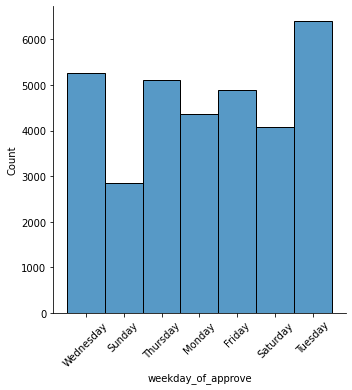

In [29]:
plt.figure(figsize = (16,8))
ax = sns.displot(shopping_days, x='weekday_of_approve')
plt.xticks(rotation=45)

## Задание 4

Для определения среднего количества покупок в неделю для каждого пользователя, смерджим таблицу orders с таблицей users и полученную таблицу примерджим к таблице items. Затем посчитаем среднее количество покупок в месяц и разделим на количество недель в каждом месяце

In [30]:
orders['month_of_approved'] = orders.order_approved_at.dt.to_period('M')

In [31]:
purchases_in_week = items[['order_id']] \
    .merge(orders[['order_id', 'customer_id', 'month_of_approved']] \
        .merge(users[['customer_id', 'customer_unique_id']], 
            on='customer_id', 
            how='left'
            ), 
            on='order_id'
        )
purchases_in_week.head()

,order_id,customer_id,month_of_approved,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,3ce436f183e68e07877b285a838db11a,2017-09,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,f6dd3ec061db4e3987629fe6b26e5cce,2017-04,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,6489ae5e4333f3693df5ad4372dab6d3,2018-01,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,d4eb9395c8c0431ee92fce09860c5a06,2018-08,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,58dbd0b2d70206bf40e62cd34e84d795,2017-02,64b576fb70d441e8f1b2d7d446e483c5


In [32]:
purchases_in_week = purchases_in_week \
    .groupby(['customer_unique_id', 'month_of_approved'], as_index=False) \
    .agg({'order_id': 'nunique'}) 
purchases_in_week.head()

,customer_unique_id,month_of_approved,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1
2,0000f46a3911fa3c0805444483337064,2017-03,1
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1


In [33]:
purchases_in_week['order_id'] = purchases_in_week['order_id'] / purchases_in_week['month_of_approved'] \
    .apply(lambda x: x.days_in_month) * 7 

In [34]:
purchases_in_week = purchases_in_week.pivot(index='customer_unique_id', columns='month_of_approved', values='order_id').fillna(0)
purchases_in_week.head()

month_of_approved,2016-09,2016-10,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,...,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.225806,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [35]:
purchases_in_week.mean()

month_of_approved
2016-09    0.000002
2016-10    0.000734
2016-12    0.000002
2017-01    0.001780
2017-02    0.004502
2017-03    0.006272
2017-04    0.005784
2017-05    0.008665
2017-06    0.007895
2017-07    0.009282
2017-08    0.010217
2017-09    0.010428
2017-10    0.010729
2017-11    0.017875
2017-12    0.013701
2018-01    0.016899
2018-02    0.017491
2018-03    0.017204
2018-04    0.016562
2018-05    0.016679
2018-06    0.015058
2018-07    0.014589
2018-08    0.015637
2018-09    0.000002
Freq: M, dtype: float64

## Задание 5

Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким retention на 3й месяц.

Для проведения когортного анализа объединим пользователей в группы, по месяцу совершения покупки за период с января 2017 
по декабрь 2017.

In [ ]:
startPeriod = pd.to_datetime('2017-01').to_period('M')
endPeriod = pd.to_datetime('2017-12').to_period('M')
cohort_df = pd.DataFrame(columns=['Cohort', 'CohortSize', 'Month', 'NumCustomers'])
NoCohort = 1
                                                  
while startPeriod <= endPeriod:
    cohort = purchases[purchases.month_of_approved == startPeriod].customer_unique_id.unique()
    retentionPeriod = startPeriod + 1
    period = 1
    while retentionPeriod <= endPeriod:
        retention = purchases[purchases['month_of_approved'] == retentionPeriod][purchases[purchases['month_of_approved'] == retentionPeriod].customer_unique_id.isin(cohort)].customer_unique_id.nunique()
        cohort_df = cohort_df.append({'Cohort': '{}'.format(NoCohort), 'CohortSize': len(cohort), 'Month': period, 'NumCustomers': retention},  ignore_index=True)
        retentionPeriod = retentionPeriod + 1
        period = period + 1
    startPeriod = startPeriod + 1
    NoCohort = NoCohort + 1
cohort_df['Cohort'] = cohort_df.Cohort.astype('int')
cohort_df['Month'] = cohort_df.Month.astype('int')
cohort_df.head()

In [ ]:
cohort_df = cohort_df.pivot(index=['Cohort', 'CohortSize'], columns='Month', values='NumCustomers')

In [34]:
cohort_df

,Month,1,2,3,4,5,6,7,8,9,10,11
Cohort,CohortSize,,,,,,,,,,,
1,719,4,2,1,3,1,3,1,1,0,2,2
2,1693,4,4,3,7,2,4,3,1,3,2,NaN
3,2610,13,9,9,9,4,4,8,8,3,NaN,NaN
4,2333,14,6,4,7,6,8,6,8,NaN,NaN,NaN
5,3590,19,17,16,11,12,15,7,NaN,NaN,NaN,NaN
6,3165,17,12,13,10,13,12,NaN,NaN,NaN,NaN,NaN
7,3848,23,15,8,14,8,NaN,NaN,NaN,NaN,NaN,NaN
8,4234,31,21,12,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4191,31,24,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из полученного датафрейма мы видим когорту размером 3590 с максимальным retention на 3-й месяц - 16 

## Задание 6

Для RFM-сегментации пользователей я выбрал следующие метрики:
    R - время от последней покупки пользователя до текущей даты 
    F - суммарное количество покупок у пользователя за всё время 
    M - сумма покупок за всё время


In [48]:
pivot_table = items[['order_id', 'price']] \
    .merge(orders[['order_id', 'customer_id', 'month_of_approved', 'order_approved_at']] \
        .merge(users[['customer_id', 'customer_unique_id']], 
            on='customer_id', 
            how='left'
            ), 
            on='order_id'
        )

In [49]:
print('РассматриваемыЙ период от {} до {}'.format(pivot_table['order_approved_at'].min(),
                                    pivot_table['order_approved_at'].max()))

РассматриваемыЙ период от 2016-09-15 12:16:38 до 2018-09-03 17:40:06


Определим сегодняшнюю дату (дата последней покупки + 1 день)


In [ ]:
NOW = pivot_table['order_approved_at'].max() + timedelta(days=1)

Добавим колонку с количеством дней от даты совершения покупки до сегодняшнего дня

In [51]:
pivot_table['days_since_order'] = pivot_table.order_approved_at.apply(lambda x: (NOW - x).days)

In [52]:
pivot_table.head()

,order_id,price,customer_id,month_of_approved,order_approved_at,customer_unique_id,days_since_order
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,3ce436f183e68e07877b285a838db11a,2017-09,2017-09-13 09:45:35,871766c5855e863f6eccc05f988b23cb,356.0
1,00018f77f2f0320c557190d7a144bdd3,239.90,f6dd3ec061db4e3987629fe6b26e5cce,2017-04,2017-04-26 11:05:13,eb28e67c4c0b83846050ddfb8a35d051,496.0
2,000229ec398224ef6ca0657da4fc703e,199.00,6489ae5e4333f3693df5ad4372dab6d3,2018-01,2018-01-14 14:48:30,3818d81c6709e39d06b2738a8d3a2474,233.0
3,00024acbcdf0a6daa1e931b038114c75,12.99,d4eb9395c8c0431ee92fce09860c5a06,2018-08,2018-08-08 10:10:18,af861d436cfc08b2c2ddefd0ba074622,27.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,58dbd0b2d70206bf40e62cd34e84d795,2017-02,2017-02-04 14:10:13,64b576fb70d441e8f1b2d7d446e483c5,577.0


Для расчета метрики Reсency для кажого клиента определим минимальное количество дней из колонки "days_since_order", т.е.
время от последней покупки пользователя до сегодняшней даты. 
Метрика Frequency это общее число заказов сделанное пользователем за весь период, (количество уникальных "order_id").
Метрика Monetary - количество денег сумма покупок пользователя за все время (сумма значений колонки "price") 

In [54]:
rfm = pivot_table.groupby('customer_unique_id', as_index=False) \
    .agg({'days_since_order': 'min', 'order_id': 'nunique', 'price': 'sum'})
rfm.rename(columns={'customer_unique_id': 'CustomerID',
                          'days_since_order': 'Recency', 
                          'order_id': 'Frequency', 
                          'price': 'Monetary'}, inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,18.90
2,0000f46a3911fa3c0805444483337064,542.0,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326.0,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293.0,1,180.00


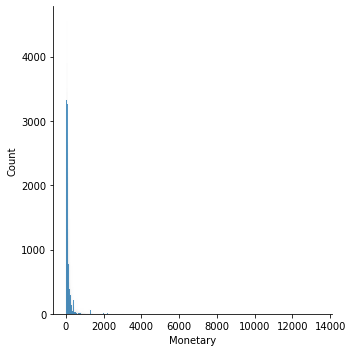

In [55]:
sns.displot(data=rfm, x=rfm.Monetary)

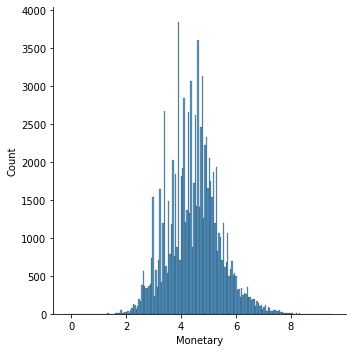

In [56]:
sns.displot(data=rfm, x=np.log(rfm.Monetary))

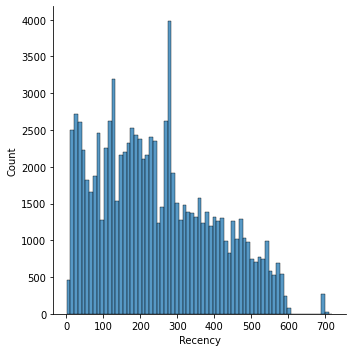

In [57]:
sns.displot(data=rfm, x='Recency')

In [58]:
rfm.Frequency.sort_values().tail()

10281     7
37532     7
75560     7
23302     9
52597    16
Name: Frequency, dtype: int64

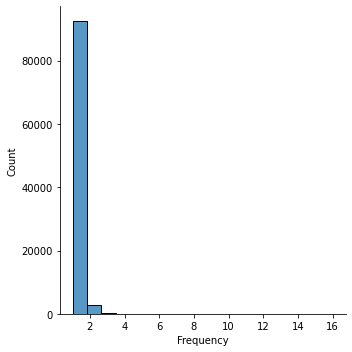

In [59]:
sns.displot(data=rfm, x=rfm.Frequency)

Добавим перцентили распределения метрик

In [64]:
quintiles = rfm[['Recency', 'Monetary']].quantile([.2, .6, .9]).to_dict()
quintiles_f = rfm[['Frequency']].quantile([.1, .99]).to_dict()
quintiles

{'Recency': {0.2: 98.0, 0.6: 273.0, 0.9: 472.0},
 'Monetary': {0.2: 39.9, 0.6: 109.9, 0.9: 284.0}}

In [65]:
quintiles_f

{'Frequency': {0.1: 1.0, 0.99: 2.0}}

Установим диапазоны границ метрик.





Для метрики Recency используем следующие границы:
1. 0-30 дней
2. 31-90 дней
3. более 91 дней

Подавляющее число пользователей (более 90%) совершили только одну покупку, а максимальное число покупок, совершенных 
пользователем - 16
1. 1 заказ
2. более 1 заказа

Распределение сумм покупок смещено к нулевой отметке, максимальная сумма покупок у пользователя составляет 13440 рублей,
при этом 80% перцентиль показывает сумму покупок 389 рублей.
1. 0-100 рублей
2. 101-300 рублей
3. более 300 рублей


In [69]:
def r_score(x):
    if x <= 30:
        return 3
    elif x <= 90:
        return 2  
    else:
        return 1

def f_score(x):
    if x == 1:
        return 1
    else:
        return 2
    
def m_score(x):
    if x <= 100:
        return 1
    elif x <= 300:
        return 2
    else:
        return 3
    

In [70]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['Monetary'].apply(lambda x: m_score(x))

Добавим столбец RFM_Score

In [72]:
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,129.90,1,1,2,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,542.0,1,69.00,1,1,1,111
3,0000f6ccb0745a6a4b88665a16c9f078,326.0,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293.0,1,180.00,1,1,2,112
